## 🔑 OpenAI API Key

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_API_KEY")

## 📚 Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from IPython.display import display

import traceback
import re # To clean the LLM Output

## 📥 Load datasets


In [3]:
yt_df = pd.read_csv("../data/youtube_data.csv")
rd_df = pd.read_csv("../data/reddit_data.csv")

## 🧹 Previews


In [4]:
print("🎥 YouTube data shape:", yt_df.shape)
print("📕 Reddit data shape:", rd_df.shape)

🎥 YouTube data shape: (750, 6)
📕 Reddit data shape: (196, 13)


## 🎯 Aggregated Sentiment Analysis


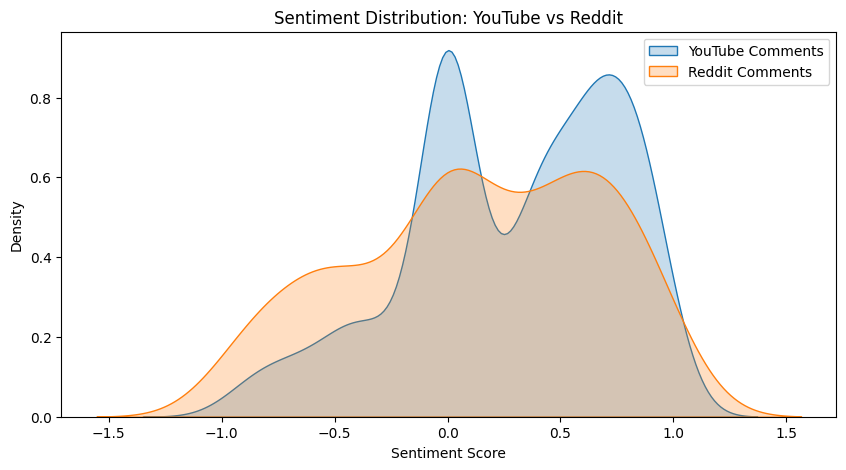

In [5]:
# Create plot
plt.figure(figsize=(10, 5))
sns.kdeplot(yt_df['comment_sentiment'], label='YouTube Comments', fill=True)
sns.kdeplot(rd_df['comment_sentiment'], label='Reddit Comments', fill=True)
plt.title('Sentiment Distribution: YouTube vs Reddit')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()

# ✅ Save BEFORE showing (Otherwise, a blank image will be saved)
plt.savefig("../data/sentiment_distribution.png", bbox_inches="tight")

# Then show (for notebook preview)
plt.show()
plt.close()

## 📊 Average Sentiment Comparison


In [6]:
avg_sentiments = pd.DataFrame({
    'Platform': ['YouTube', 'Reddit'],
    'Avg Comment Sentiment': [yt_df['comment_sentiment'].mean(), rd_df['comment_sentiment'].mean()]
})
display(avg_sentiments)

,Platform,Avg Comment Sentiment
0,YouTube,0.283768
1,Reddit,0.128706


## 🧠 Create grouped summaries for LLM


In [7]:
# Instantiating OpenAI
client = OpenAI(api_key=OPENAI_KEY)

In [8]:
topics = yt_df['video_title'].unique()
final_outputs = []

for topic in topics:
    yt_comments = yt_df[yt_df['video_title'] == topic]['comment'].dropna().tolist()
    reddit_rows = rd_df[rd_df['youtube_title'] == topic]
    reddit_post = reddit_rows['reddit_post_title'].unique()[0] if not reddit_rows.empty else "No Reddit post found"
    reddit_comments = reddit_rows['comment'].dropna().tolist()

    if not yt_comments and not reddit_comments:
        continue

    # ✅ Cleaned, limited comments for brevity
    yt_sample = "\n- ".join(yt_comments[:3])
    rd_sample = "\n- ".join(reddit_comments[:3])

    # ✅ Full prompt passed to model
    user_prompt = f"""
Video Title: {topic}
Reddit Post Title: {reddit_post}

🟦 YouTube Comments:
- {yt_sample}

🟥 Reddit Comments:
- {rd_sample}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are a social media analyst. Analyze public perception around this topic using the comments from YouTube and Reddit. Provide a concise summary and highlight any sentiment trends or contrasting opinions between platforms."
                },
                {
                    "role": "user",
                    "content": user_prompt.strip()
                }
            ],
            temperature=0.7
        )
        output = response.choices[0].message.content
    except Exception as e:
        output = f"⚠️ Error for topic: {topic} | {str(e)}"
        print(traceback.format_exc())

    final_outputs.append({
        "topic": topic,
        "reddit_post_title": reddit_post,
        "llm_analysis": output
    })

## 📋 Show results

In [9]:
llm_df = pd.DataFrame(final_outputs)

# Using Regular Expressions to clean the LLM Output
def clean_llm_output(text):
    # Remove Markdown bold/italic
    text = re.sub(r"\*\*(.*?)\*\*", r"\1", text)
    text = re.sub(r"\*(.*?)\*", r"\1", text)
    # Remove Headers
    text = re.sub(r"\#+", r"", text)
    # Remove newlines and excessive spacing
    text = re.sub(r"\n+", "\n", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip()

# Applying the cleaning function to the 'llm_analysis' column
llm_df['llm_analysis'] = llm_df['llm_analysis'].apply(clean_llm_output)

llm_df.head()

,topic,reddit_post_title,llm_analysis
0,FULL SEGMENT: Randy Orton ROCKS John Cena with...,Post WWE Raw 4/21/2025 Show Discussion Thread ...,"Based on the comments from YouTube and Reddit,..."
1,Can We Beat Josh Allen & Jon Rahm in a Golf Ma...,I’m pretty sure my Wife’s DM hates me.,"The YouTube comments on the video ""Can We Beat..."
2,"Carrie Underwood Praises with ""How Great Thou ...",No Reddit post found,"Since there are no Reddit comments available, ..."
3,skibidi toilet 78,I just watched skibidi toilet 78,Based on the comments from YouTube and Reddit ...
4,Cardinal Dolan on significance of Pope Francis...,"The Holy Father, Pope Francis, has died.",The public perception surrounding the reported...


In [10]:
for llm_analysis in llm_df['llm_analysis']:
    print(llm_analysis, end="\n\n\n")

Based on the comments from YouTube and Reddit, public perception of the WWE Raw segment featuring Randy Orton and John Cena is mixed, with some notable trends and contrasting opinions between the platforms. YouTube Comments:
- Nostalgia and Rivalry: One commenter quoted Orton's classic line to Cena, "we are destined to this forever," suggesting a sense of nostalgia and the enduring nature of their rivalry. This indicates that fans enjoy the long-standing feud between these two iconic wrestlers.
- Character Development: There is a critical view regarding character roles, with one user expressing disinterest in Cena's heel turn and a positive reception of Orton as a face. This highlights a preference for Orton's current character arc while showing skepticism towards Cena's new direction.
- Comparison to CM Punk: A comment likens Orton's current trajectory to that of CM Punk, suggesting that Orton may be aiming for a similar level of impact or controversy in his career. Reddit Comments:
-

## Saving to csv

In [11]:
llm_df.to_csv("../data/llm_insights.csv", index=False)